In [1]:
# Imporjting necessary packages
import spacy # general purpose NLP(its easy to build system for information extraction)
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # t-distributed stochastic neighbor embedding(Unsupervised non-linear dimensional reduction technique 4 data exploration nd visulizing high-dimensionaldata)
nlp = spacy.load('en_core_web_sm')

import gensim

import io

import torch
import torch.nn as nn  #(used to train and build the layers of neural network such as input, hidden nd output)
import torch.nn.functional as F
from torch import optim #package implementing various optimization algorithms
from torch.utils.data import TensorDataset, DataLoader, random_split

**Loading Train Data**

In [2]:
trainPosPath = open("/kaggle/input/positive-words/pos.txt",'r')
trainNegPath = open("/kaggle/input/negative-words/neg.txt",'r')
posList = trainPosPath.read().split("\n")[:5000]
negList = trainNegPath.read().split("\n")[:5000]
print(len(posList))
print(posList[4999])
print(len(negList))
print(negList[4999])

5000
provides a porthole into that noble , trembling incoherence that defines us all . 
5000
enigma is well-made , but it's just too dry and too placid . 


**Functions for sentence preprocessing**

In [3]:
def remPunc(text):
  if type(text) == str:
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', '', text.lower())
    return text

def refineSentence(tempSentence):
  tokens = nlp(tempSentence)
  filtered = []
  for token in tokens:
    textAfterRemPunc = remPunc(token.lemma_)
    if(textAfterRemPunc != ''):
      filtered.append(textAfterRemPunc)
  return filtered

**# PreProcessing the Train Data**

In [4]:
posPreProccessedList = [refineSentence(sentence) for sentence in posList]
negPreProccessedList = [refineSentence(sentence) for sentence in negList]

In [5]:
print(posPreProccessedList[8])
print(negPreProccessedList[3])

['steer', 'turn', 'in', 'a', 'snappy', 'screenplay', 'that', 'curl', 'at', 'the', 'edge', 'it', 'be', 'so', 'clever', 'you', 'want', 'to', 'hate', 'it', 'but', 'he', 'somehow', 'pull', 'it', 'off']
['garbus', 'discard', 'the', 'potential', 'for', 'pathological', 'study', 'exhume', 'instead', 'the', 'skewed', 'melodrama', 'of', 'the', 'circumstantial', 'situation']


**Getting Word2Vec Embeddings**

In [6]:
embeddingsWord2Vec = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
# if you vector file is in binary format, change to binary=True

**Getting GloVe Embeddings**

In [7]:
embeddingsGloVe = {}
dim = 300
with open("/kaggle/input/glove6b300dtxt/glove.6B.300d.txt", 'r', encoding="utf-8") as wordEmbeddings:
  for line in wordEmbeddings:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddingsGloVe[word]=vector

**Getting FastText Embeddings**

In [8]:
def LoadFastText(PATH_TO_FASTTEXT):
    input_file = io.open(PATH_TO_FASTTEXT, 'r', encoding='utf-8', newline='\n', errors='ignore')
    no_of_words, vector_size = map(int, input_file.readline().split())
    # word_to_vector: Dict[str, List[float]] = dict()
    word_to_vector = {}
    for i, line in enumerate(input_file):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vector = list(map(float, tokens[1:]))
        assert len(vector) == vector_size
        word_to_vector[word] = vector
    return word_to_vector

embeddingsFastText = LoadFastText("/kaggle/input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec")

**Dynamic Meta Embedding(Averaging the three embeddings)**

In [9]:
def dynamicMetaEmbedding(word):
  c = 0
  finalEmbedding = np.zeros(dim)
  if word in embeddingsWord2Vec:
    finalEmbedding += embeddingsWord2Vec[word]
    c += 1
  if word in embeddingsGloVe:
    finalEmbedding += embeddingsGloVe[word]
    c += 1
  if word in embeddingsFastText:
    finalEmbedding += embeddingsFastText[word]
    c += 1
  return np.array(finalEmbedding)

Function to convert refined sentence to average sentence vector

In [10]:
def sentenceToAvgWordEmbeddings(preProccessedList):
  preProccessedListVectors = []
  for preProcessedWordList in preProccessedList:
    tempList = []
    for word in preProcessedWordList:
      tempList.append(dynamicMetaEmbedding(word))
    preProccessedListVectors.append(tempList)

  sentenceVector = []
  for vectorsOfWords in preProccessedListVectors:
    if(len(vectorsOfWords) == 0):
      continue
    avgVec = [0 for i in range(dim)]
    for wordVec in vectorsOfWords:
      avgVec += wordVec
    avgVec = [i/len(vectorsOfWords) for i in avgVec]
    sentenceVector.append(avgVec)
  return sentenceVector

Training Data words to Word Vectors

In [11]:
posSentenceVector = sentenceToAvgWordEmbeddings(posPreProccessedList)
negSentenceVector = sentenceToAvgWordEmbeddings(negPreProccessedList)

In [12]:
lenPos = len(posSentenceVector)
lenNeg = len(negSentenceVector)
nSamples = lenPos+lenNeg

print(lenPos)
print(lenNeg)
print(nSamples)

5000
5000
10000


Appending the labels and shuffling.

In [13]:
posSentenceVector = np.array(posSentenceVector)
posLabel = np.array([1 for i in range(lenPos)]).reshape(lenPos,1)

negSentenceVector = np.array(negSentenceVector)
negLabel = np.array([0 for i in range(lenNeg)]).reshape(lenNeg,1)

In [14]:
my_x = np.concatenate((posSentenceVector,negSentenceVector), axis = 0)
my_y = np.concatenate((posLabel,negLabel), axis = 0)
my_y = my_y.reshape((10000))
trainSize = int(nSamples*(0.8))
valSize = nSamples - trainSize
tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)
tensor_y = tensor_y.type(torch.LongTensor)
trainDatasetTensor = TensorDataset(tensor_x,tensor_y) # create your datset
trainData, validData = random_split(trainDatasetTensor, [trainSize,valSize])

trainDataLoader = DataLoader(trainData, batch_size = 32)
validDataLoader = DataLoader(validData, batch_size = 32)

In [15]:
print(tensor_y.shape)

torch.Size([10000])


t-SNE and Plotting Graph

In [16]:
dataTSNE = np.concatenate((posSentenceVector,negSentenceVector), axis = 0)
tSNE = TSNE(learning_rate = 100)
tSNE_features = tSNE.fit_transform(dataTSNE)

(10000, 2)


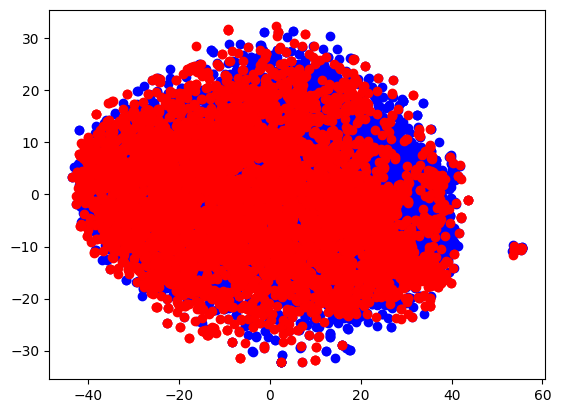

In [17]:
print(tSNE_features.shape)
pos_tsne = (tSNE_features[:lenPos]).T
neg_tsne = (tSNE_features[lenPos:]).T
plt.scatter(pos_tsne[0], pos_tsne[1],color = 'b')
plt.scatter(neg_tsne[0], neg_tsne[1],color = 'r')
plt.show()

In [18]:
# Loading Test Data

In [19]:
testPath = open("/kaggle/input/test-data/testdata.txt",'r')
testDataList = testPath.read().split("\n")

testPosList = testDataList[:331]
testNegList = testDataList[331:]

print(len(testPosList))
print(len(testNegList))

testPosPreProccessedList = [refineSentence(sentence) for sentence in testPosList]
testNegPreProccessedList = [refineSentence(sentence) for sentence in testNegList]

testPosSentenceVector = sentenceToAvgWordEmbeddings(testPosPreProccessedList)
testNegSentenceVector = sentenceToAvgWordEmbeddings(testNegPreProccessedList)

testLenPos = len(testPosSentenceVector)
testLenNeg = len(testNegSentenceVector)
nSamples_test = testLenPos+testLenNeg
# print(testLenPos)
# print(testLenNeg)
# print(nSamples_test)

testPosSentenceVector = np.array(testPosSentenceVector)
testPosLabel = np.array([1 for i in range(testLenPos)]).reshape(testLenPos,1)

testNegSentenceVector = np.array(testNegSentenceVector)
testNegLabel = np.array([0 for i in range(testLenNeg)]).reshape(testLenNeg,1)

testMy_x = np.concatenate((testPosSentenceVector,testNegSentenceVector), axis = 0)
testMy_y = np.concatenate((testPosLabel,testNegLabel), axis = 0)
testTensor_x = torch.Tensor(testMy_x) # transform to torch tensor
testTensor_y = torch.Tensor(testMy_y)
testDatasetTensor = TensorDataset(testTensor_x,testTensor_y) # create your datset

testDataLoader = DataLoader(testDatasetTensor)

331
331


In [20]:
class NeuralNet(nn.Module):
  def __init__(self, inputSize, noOfNeuronsInHiddenLayer, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = inputSize
    self.l1 = nn.Linear(inputSize, noOfNeuronsInHiddenLayer) 
    self.d1 = nn.Dropout(0.25)
    self.relu1 = nn.ReLU()
    self.l2 = nn.Linear(noOfNeuronsInHiddenLayer,num_classes)
    self.softmax=nn.Softmax(dim=1)

  def forward(self, x):
    out = self.l1(x)
    out = self.d1(out)
    out = self.relu1(out)
    out = self.l2(out)
    out = self.softmax(out)
    return out

In [21]:
noOfNeuronsInHiddenLayer = 400
DAN2Layer = NeuralNet(dim, noOfNeuronsInHiddenLayer, 2)

In [22]:
class DAN:
  def __init__(self, trainDataLoader, validDataLoader, epochs, NNobj, learningRate):
    self.trainDataLoader = trainDataLoader
    self.validDataLoader = validDataLoader
    self.epochs = epochs
    self.NNobj = NNobj
    self.cross_entropy_loss = nn.CrossEntropyLoss()

    self.optimizer = optim.Adam(self.NNobj.parameters(), lr = learningRate)

    self.trainLossList = []
    self.validLossList = []
    self.trainLossListPlotting = []
    self.validLossListPlotting = []

  def fit(self):
    trainData, validData = self.trainDataLoader, self.validDataLoader
    for i in range(self.epochs):
      self.trainLossList = []
      self.validLossList = []
      accuracyListTrain = []
      for batch in trainData:
        self.NNobj.train()
        x, y = batch
#         b = x.size(0)
#         print(b)
#         x = x.view(b, -1)
#         print(x)

        forwardValue = self.NNobj(x)
        costFunction_J = self.cross_entropy_loss(forwardValue, y)
        self.NNobj.zero_grad()
        costFunction_J.backward()
        self.optimizer.step()
        self.trainLossList.append(costFunction_J.item())
        accuracyListTrain.append(y.eq(forwardValue.detach().argmax(dim = 1)).float().mean())
          
      accuracyListVal = []
      for batch in validData:
        self.NNobj.eval()
        x, y = batch
        with torch.no_grad():
          forwardValue = self.NNobj(x)
          costFunction_J = self.cross_entropy_loss(forwardValue, y)
        self.validLossList.append(costFunction_J.item())
        accuracyListVal.append(y.eq(forwardValue.detach().argmax(dim = 1)).float().mean())
      
      self.trainLossListPlotting.append(torch.tensor(self.trainLossList).mean())
      self.validLossListPlotting.append(torch.tensor(self.validLossList).mean())
      accuracyTrain = torch.tensor(accuracyListTrain).mean() * 100
      accuracyVal = torch.tensor(accuracyListVal).mean() * 100

      print('At Epoch Number: ' + str(i+1) +'; Train Loss= ' + str("{:.2f}".format(torch.tensor(self.trainLossList).mean()))+'; Validation Loss= ' + str("{:.2f}".format(torch.tensor(self.validLossList).mean())) + "; " + "Train Accuracy = ", "{:.2f}".format(accuracyTrain), "%" + "; " + "Validation Accuracy = ", "{:.2f}".format(accuracyVal), "%")

  def predict(self,testData):
    accuracyListPred = []
    for batch in testData:
      x, y = batch

      with torch.no_grad():
        forwardValue = self.NNobj(x)
          
      accuracyListPred.append(y.eq(forwardValue.detach().argmax(dim = 1)).float().mean())
    accuracy = torch.tensor(accuracyListPred).mean() * 100
    print('\033[1m' + "Review Classification Accuracy on Test Data = ", "{:.2f}".format(accuracy), " %" + '\033[0m' )

  def plotLossCurve(self, flag):
    x = [(i+1) for i in range(self.epochs)]
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    tempStr = "Loss curve for "
    if(flag == 0):
        tempStr += "Train Data"
        plt.plot(x,self.trainLossListPlotting)
    else:
        tempStr += "Validation Data"
        plt.plot(x,self.validLossListPlotting)
    plt.title(tempStr)
    plt.show()

In [23]:
epochs = 20
learningRate = 1e-4
DANObj = DAN(trainDataLoader,validDataLoader,epochs,DAN2Layer,learningRate)
DANObj.fit()


At Epoch Number: 1; Train Loss= 0.67; Validation Loss= 0.65; Train Accuracy =  63.75 %; Validation Accuracy =  67.16 %
At Epoch Number: 2; Train Loss= 0.62; Validation Loss= 0.60; Train Accuracy =  70.24 %; Validation Accuracy =  70.98 %
At Epoch Number: 3; Train Loss= 0.59; Validation Loss= 0.58; Train Accuracy =  72.19 %; Validation Accuracy =  72.37 %
At Epoch Number: 4; Train Loss= 0.58; Validation Loss= 0.57; Train Accuracy =  73.58 %; Validation Accuracy =  72.97 %
At Epoch Number: 5; Train Loss= 0.57; Validation Loss= 0.56; Train Accuracy =  74.43 %; Validation Accuracy =  73.81 %
At Epoch Number: 6; Train Loss= 0.56; Validation Loss= 0.56; Train Accuracy =  74.86 %; Validation Accuracy =  74.06 %
At Epoch Number: 7; Train Loss= 0.55; Validation Loss= 0.55; Train Accuracy =  75.07 %; Validation Accuracy =  74.50 %
At Epoch Number: 8; Train Loss= 0.55; Validation Loss= 0.55; Train Accuracy =  75.25 %; Validation Accuracy =  74.21 %
At Epoch Number: 9; Train Loss= 0.55; Validation

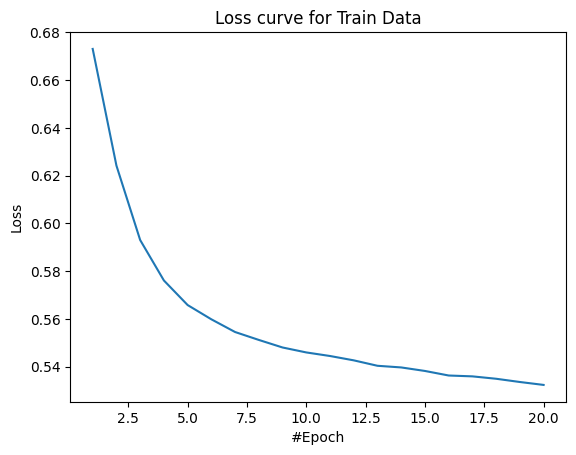

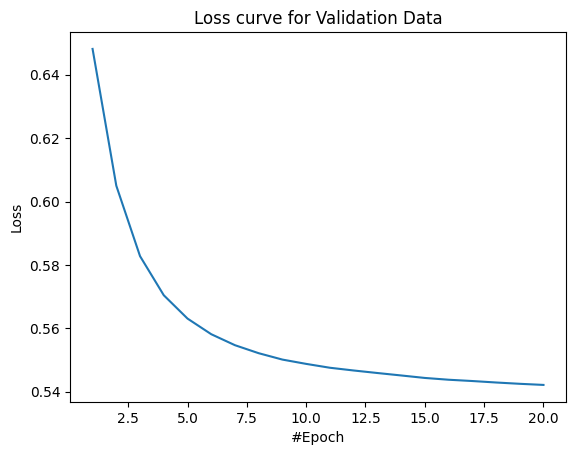

In [24]:
DANObj.plotLossCurve(0)
DANObj.plotLossCurve(1)

In [25]:
DANObj.predict(testDataLoader)

Review Classification Accuracy on Test Data =  75.23  %
